## Importing Packages and Libraries

In [1]:
# Importing required packages

import numpy as np # for linear algebra
import pandas as pd # for data processing, CSV file
import matplotlib.pyplot as plt # data visualization library
%matplotlib inline
import seaborn as sns # interactive visualization library built on top on matplotlib

data = pd.read_csv('/kaggle/input/train.csv') # importing training data

In [2]:
# Checking the head of the data
data.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [3]:
print(len(data[data.label == 0]), 'Non-Hatred Tweets')
print(len(data[data.label == 1]), 'Hatred Tweets')
# Class distribution in this data seems to be imbalanced.
# F1 score should be used fot model performance evaluation in such situation. 

29720 Non-Hatred Tweets
2242 Hatred Tweets


### Preprocessing

In [4]:
#importing different libraries for analysis, processing and classification
import nltk
from sklearn import re #regular expression for text processing
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer #word stemmer class
lemma = WordNetLemmatizer()
from wordcloud import WordCloud, STOPWORDS
from nltk import FreqDist

# Vectorizers
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression #classification model
from sklearn.metrics import confusion_matrix, classification_report, f1_score # performance evaluation criteria

### Preprocessing the tweet column

In [5]:
def normalizer(tweet):
    tweets = " ".join(filter(lambda x: x[0]!= '@' , tweet.split()))
    tweets = re.sub('[^a-zA-Z]', ' ', tweets)
    tweets = tweets.lower()
    tweets = tweets.split()
    tweets = [word for word in tweets if not word in set(stopwords.words('english'))]
    tweets = [lemma.lemmatize(word) for word in tweets]
    tweets = " ".join(tweets)
    return tweets

In [6]:
data['normalized_text'] = data.tweet.apply(normalizer)

**Extracting words with hashtag for further analysis**

In [7]:
def extract_hashtag(tweet):
    tweets = " ".join(filter(lambda x: x[0]== '#', tweet.split()))
    tweets = re.sub('[^a-zA-Z]',' ',  tweets)
    tweets = tweets.lower()
    tweets = [lemma.lemmatize(word) for word in tweets]
    tweets = "".join(tweets)
    return tweets

In [8]:
data['hashtag'] = data.tweet.apply(extract_hashtag)

In [9]:
data.head()

,id,label,tweet,normalized_text,hashtag
0,1,0,@user when a father is dysfunctional and is s...,father dysfunctional selfish drag kid dysfunct...,run
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks lyft credit use cause offer wheelchair ...,lyft disapointed getthanked
2,3,0,bihday your majesty,bihday majesty,
3,4,0,#model i love u take with u all the time in ...,model love u take u time ur,model
4,5,0,factsguide: society now #motivation,factsguide society motivation,motivation


> **Exploratory Data Analysis**

**To Create Cloud of words for all words and hatred words**

In [10]:
# all tweets 
all_words = " ".join(data.normalized_text)
#print(all_words)

In [11]:
# Hatred tweets
hatred_words = " ".join(data[data['label']==1].normalized_text)
#print(hatred_words)

### All tweets cloudword

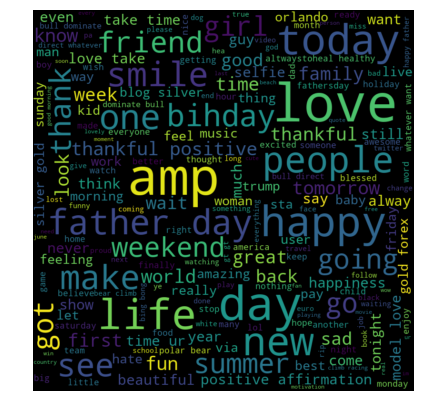

In [12]:
wordcloud = WordCloud(height=800, width=800, max_font_size = 110, stopwords=STOPWORDS, background_color='black')
wordcloud = wordcloud.generate(all_words)
plt.figure(figsize = (10,7))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis('off')
plt.show()

### Hatred tweets cloudword

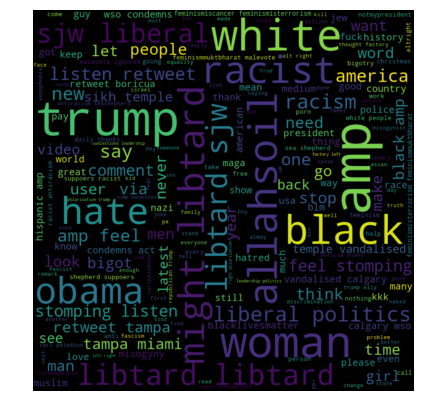

In [13]:
wordcloud = WordCloud(height=800, width=800, max_font_size = 110, stopwords=STOPWORDS, background_color='black')
wordcloud = wordcloud.generate(hatred_words)
plt.figure(figsize = (10,7))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis('off')
plt.show()

## Analysing Hashtag words

**plotting the most common hashtag used in tweets**
**all hashtag 
hatred hashtag**

In [14]:
# from nltk import FreqDist
freq_all_hashtag = FreqDist(list(" ".join(data.hashtag).split())).most_common(12)
freq_all_hashtag

[('love', 1591),
 ('positive', 879),
 ('smile', 577),
 ('healthy', 576),
 ('thankful', 471),
 ('fun', 463),
 ('life', 438),
 ('summer', 392),
 ('model', 366),
 ('cute', 364),
 ('affirmation', 363),
 ('blog', 353)]

In [15]:
freq_hatred_hashtag = FreqDist(list(" ".join(data[data['label']==1]['hashtag']).split())).most_common(12)
freq_hatred_hashtag

[('trump', 134),
 ('politics', 95),
 ('allahsoil', 92),
 ('libtard', 76),
 ('liberal', 75),
 ('sjw', 74),
 ('retweet', 63),
 ('miami', 46),
 ('black', 44),
 ('hate', 32),
 ('tampa', 32),
 ('s', 28)]

In [16]:
allhashtag = pd.DataFrame(freq_all_hashtag, columns=['words', 'frequency'])
hatredhashtag = pd.DataFrame(freq_hatred_hashtag, columns=['words', 'frequency'])
print(allhashtag.head())
print(hatredhashtag.head())

      words  frequency
0      love       1591
1  positive        879
2     smile        577
3   healthy        576
4  thankful        471
       words  frequency
0      trump        134
1   politics         95
2  allahsoil         92
3    libtard         76
4    liberal         75


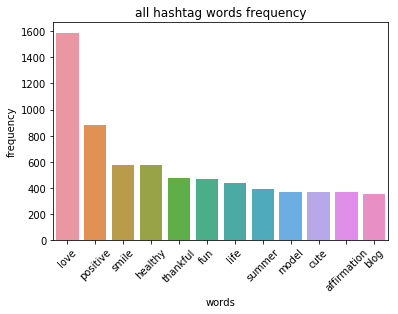

In [17]:
sns.barplot(x='words', y='frequency', data=allhashtag)
plt.xticks(rotation = 45)
plt.title('all hashtag words frequency')
plt.show()

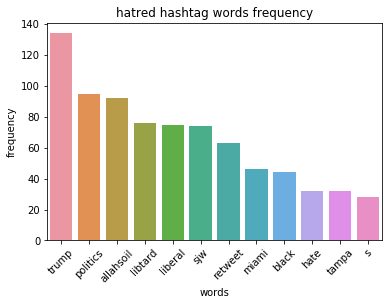

In [18]:
sns.barplot(x='words', y='frequency', data=hatredhashtag)
plt.xticks(rotation = 45)
plt.title('hatred hashtag words frequency')
plt.show()

In [19]:
# to create sparse matrix corpus is created to pass to vectorizer
corpus = []
for i in range(0,len(data.id)):
    corpus.append(data['normalized_text'][i])
#corpus

In [20]:
cv = CountVectorizer(stop_words=stopwords.words('english'))
cv.fit(corpus)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [21]:
# creating dense matrix
X = cv.transform(corpus).toarray()
y = data.iloc[:,1].values

In [22]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Classification

**Logistic Regression (Linear Model)**

In [23]:
classifier1 = LogisticRegression(C=10)
classifier1.fit(X_train, y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [24]:
y_pred = classifier1.predict(X_test)
y_prob = classifier1.predict_proba(X_test)

In [25]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(set(data.label)))
    plt.xticks(tick_marks, set(data.label), rotation=0)
    plt.yticks(tick_marks, set(data.label))
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

0.6702702702702703
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      9806
           1       0.78      0.58      0.67       742

    accuracy                           0.96     10548
   macro avg       0.88      0.79      0.82     10548
weighted avg       0.96      0.96      0.96     10548

[[9687  119]
 [ 308  434]]


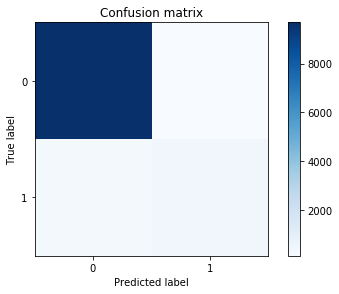

In [26]:
cm = confusion_matrix(y_test, y_pred)
print(f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(cm)
plot_confusion_matrix(cm)

> **Checking with TF-IDF vectorizer**

*** Unigram, bi gram is used wih min_df = 10***

In [27]:
tfidf = TfidfVectorizer(ngram_range=(1,3), min_df=10, stop_words=stopwords.words('english'))
X1 = tfidf.fit_transform(corpus)

In [28]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y, test_size=0.33, random_state=42)
classifier2 = LogisticRegression(C=10)
classifier2.fit(X1_train, y1_train)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [29]:
y1_pred = classifier2.predict(X1_test)
y1_prob = classifier2.predict_proba(X1_test)

0.6308943089430895
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      9806
           1       0.80      0.52      0.63       742

    accuracy                           0.96     10548
   macro avg       0.88      0.76      0.80     10548
weighted avg       0.95      0.96      0.95     10548

[[9706  100]
 [ 354  388]]


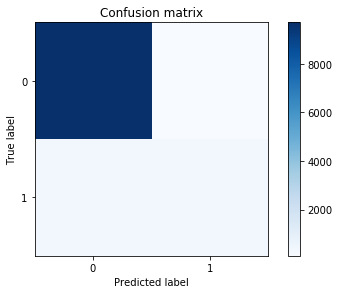

In [30]:
cm1 = confusion_matrix(y1_test, y1_pred)
print(f1_score(y1_test, y1_pred))
print(classification_report(y1_test, y1_pred))
print(cm1)
plot_confusion_matrix(cm1)

**A maximum f1 score of 0.63 is achieved at threshold of 0.5. Thus tweet with probability greater than or equal to 0.5 will be classified as hatred**

**Since class distribution is imabalance we cannot use accuracy as model performance evaluation method.**

In [31]:
threshold = np.arange(0.1,0.9,0.1)
score = [f1_score(y1_test, ((y1_prob[:,1] >= x).astype(int))) for x in threshold]

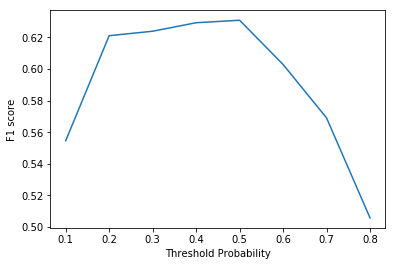

In [32]:
plt.plot(threshold, score)
plt.xlabel('Threshold Probability')
plt.ylabel('F1 score')
plt.show()

**Performing classification model on our test data** 

In [33]:
data2 = pd.read_csv('/kaggle/input/test.csv')
data2.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [34]:
data2['normalized_text'] = data2['tweet'].apply(normalizer)

In [35]:
data2.head()
# creating corpus
corpus_test = []
for i in range(0, len(data2.id)):
    corpus_test.append(data2.normalized_text[i])
#corpus_test

In [36]:
Test_X = tfidf.transform(corpus_test)

In [37]:
pred_Y = classifier2.predict(Test_X)
prob_Y = classifier2.predict_proba(Test_X)

In [38]:
data2['pred_label'] = pred_Y
scores = (prob_Y[:,1] >= 0.5).astype(int)
data2['score'] = scores

In [39]:
data2[data2.pred_label == 1]

,id,tweet,normalized_text,pred_label,score
19,31982,thought factory: bbc neutrality on right wing ...,thought factory bbc neutrality right wing fasc...,1,1
26,31989,chick gets fucked hottest naked lady,chick get fucked hottest naked lady,1,1
30,31993,i'll #never be #120 #again i'm #i'm a #thick...,never thick woman blacktina,1,1
33,31996,suppo the #taiji fisherman! no bullying! no ra...,suppo taiji fisherman bullying racism tweet ta...,1,1
110,32073,hey @user - a $14000 ivanka bracelet? do you f...,hey ivanka bracelet feel good profiting xenoph...,1,1
140,32103,@user all together this christmas: pls &amp; ...,together christmas pls amp follow national day...,1,1
141,32104,you might be a libtard if... #libtard #sjw #l...,might libtard libtard sjw liberal politics,1,1
159,32122,#people aren't protesting #trump because a #re...,people protesting trump republican trump fuher...,1,1
160,32123,at work: attorneys for white officer who shot...,work attorney white officer shot philandocasti...,1,1
164,32127,@user trump's long history of explained 1970'...,trump long history explained thru nevermypresi...,1,1


In [ ]:
data2

In [ ]:
x = True
while(x):
    tweet = input("\nTweet Something : ")
    if tweet == "exit":
        x = False
        break
    prediction = classifier2.predict(tfidf.transform([tweet]))
    if (prediction == [0]):
        print('Non-hatred Tweet')
    else:
        print('Hatred Tweet')